<a href="https://colab.research.google.com/github/kranov582/mvp-2-parte-2/blob/main/bert_movie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP de Machine Learning & Analytics - Parte 2

>


## Pedro Augusto Boller


## 1 Definição do Problema

In [1]:
# instalando dependências
! pip install transformers[torch] datasets evaluate scikit-learn matplotlib

! pip install gdown
import gdown
import os
import zipfile

import os
import pandas as pd
from datasets import load_dataset, Dataset, concatenate_datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.0 MB/s eta 0:00:00


In [9]:
# carregando dados do HF

# dataset = load_dataset("datadrivenscience/movie-genre-prediction", use_auth_token=True)

# carregando dados locais

train = 'https://raw.githubusercontent.com/kranov582/mvp-2-parte-2/main/dataset_pd_train.csv'
test = 'https://raw.githubusercontent.com/kranov582/mvp-2-parte-2/main/dataset_pd_test.csv'

dataset = load_dataset('csv', data_files={'train': train , 'test': test},
                              column_names=['id','movie_name','synopsis','genre'], skiprows=[0])

  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
treino = pd.read_csv('https://raw.githubusercontent.com/kranov582/mvp-2-parte-2/main/dataset_pd_train.csv')
treino.head()

,id,movie_name,synopsis,genre
0,44978,Super Me,A young scriptwriter starts bringing valuable ...,fantasy
1,50185,Entity Project,A director and her friends renting a haunted h...,horror
2,34131,Behavioral Family Therapy for Serious Psychiat...,This is an educational video for families and ...,family
3,78522,Blood Glacier,Scientists working in the Austrian Alps discov...,scifi
4,2206,Apat na anino,Buy Day - Four Men Widely - Apart in Life - By...,action


## 2 Preparação de Dados

In [10]:
set(dataset["train"]["genre"])

{'action',
 'adventure',
 'crime',
 'family',
 'fantasy',
 'horror',
 'mystery',
 'romance',
 'scifi',
 'thriller'}

In [11]:
dataset_train = dataset['train']
dataset_test = dataset['test']

In [12]:
dataset_pd_test = dataset["test"].to_pandas()
dataset_pd_train = dataset["train"].to_pandas()

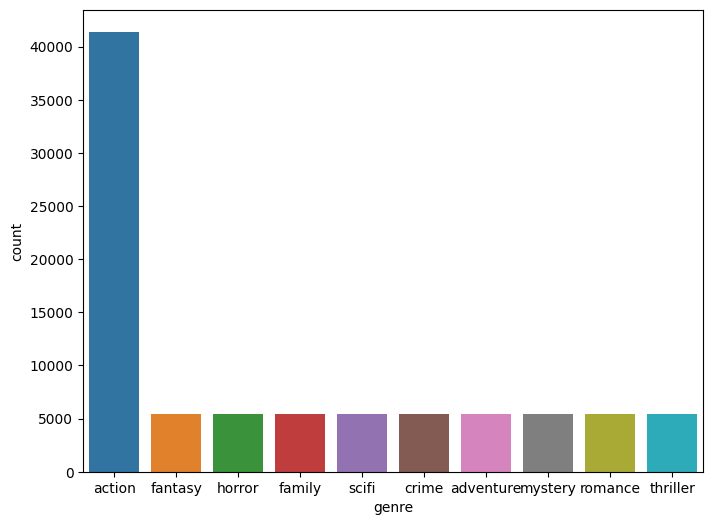

In [13]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Carregando o dataset (substitua 'seu_dataset.csv' pelo nome do seu arquivo)
data = pd.concat([dataset_pd_test, dataset_pd_train], axis=0)

plt.figure(figsize=(8, 6))

sns.countplot(x=data['genre'], data=data)
plt.show()

In [14]:
data_group = data.groupby('genre').count()
data_group

,id,movie_name,synopsis
genre,,,
action,41400,41400,41400
adventure,5400,5400,5400
crime,5400,5400,5400
family,5400,5400,5400
fantasy,5400,5400,5400
horror,5400,5400,5400
mystery,5400,5400,5400
romance,5400,5400,5400
scifi,5400,5400,5400


In [15]:
import pandas as pd

# Realizando a subamostragem aleatória da classe majoritária
class_counts = data['genre'].value_counts()
min_count = class_counts.min()

balanced_data = pd.DataFrame()

for class_label, group in data.groupby('genre'):
    sampled_group = group.sample(n=min_count, random_state=42)
    balanced_data = pd.concat([balanced_data, sampled_group])

# Exibindo o dataset balanceado
print(balanced_data['genre'].value_counts())

action       5400
adventure    5400
crime        5400
family       5400
fantasy      5400
horror       5400
mystery      5400
romance      5400
scifi        5400
thriller     5400
Name: genre, dtype: int64


In [16]:
dataset_train

Dataset({
    features: ['id', 'movie_name', 'synopsis', 'genre'],
    num_rows: 54000
})

In [17]:
dataset_pd_train.nunique()

id            54000
movie_name    43687
synopsis      46046
genre            10
dtype: int64

In [18]:
dataset_pd_test.nunique()

id            36000
movie_name    31072
synopsis      32277
genre             1
dtype: int64

In [19]:
def concat_random_split(df1, df2):

    # Separa os dados em treinamento e teste
    train_df, test_df = train_test_split(balanced_data, test_size=0.4, random_state=9)

    train = Dataset.from_pandas(train_df)
    test = Dataset.from_pandas(test_df)

    dataset = concatenate_datasets([train, test])

    # Divide o dataset em treino e teste
    dataset = dataset.train_test_split(test_size=0.4)

    return dataset

In [20]:
dataset = concat_random_split(dataset_pd_train, dataset_pd_test)

In [21]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'movie_name', 'synopsis', 'genre', '__index_level_0__'],
        num_rows: 32400
    })
    test: Dataset({
        features: ['id', 'movie_name', 'synopsis', 'genre', '__index_level_0__'],
        num_rows: 21600
    })
})

In [22]:
def merge_text_features(example):
    movie_name = example["movie_name"]
    synopsis = example["synopsis"]
    example["text"] = movie_name + "[SEP]" + synopsis
    return example

# Renomear a feature "genre" para "labels"
dataset = dataset.rename_column("genre", "label")

dataset["train"] = dataset["train"].map(merge_text_features)
dataset["test"] = dataset["test"].map(merge_text_features)

Map:   0%|          | 0/32400 [00:00<?, ? examples/s]

Map:   0%|          | 0/21600 [00:00<?, ? examples/s]

In [23]:
dataset = dataset.remove_columns(["id", "movie_name", "synopsis", "__index_level_0__"])

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 32400
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 21600
    })
})


In [25]:
set(dataset["train"]["label"])

{'action',
 'adventure',
 'crime',
 'family',
 'fantasy',
 'horror',
 'mystery',
 'romance',
 'scifi',
 'thriller'}

In [26]:
#dataset = dataset.class_encode_column(column="label")

Casting to class labels:   0%|          | 0/32400 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/21600 [00:00<?, ? examples/s]

In [28]:
set(dataset['train']['label'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [29]:
set(dataset['test']['label'])

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [ ]:
# gerando datasets menores (pra poupar tempo)

small_train_dataset = dataset["train"].shuffle(seed=9).select(range(24300))
small_dev_dataset = dataset["train"].shuffle(seed=9).select(range(24300,32400))
small_test_dataset = dataset["test"].shuffle(seed=9)

In [ ]:
small_test_dataset.info

DatasetInfo(description='', citation='', homepage='', license='', features={'label': ClassLabel(names=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], id=None), 'text': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name=None, config_name=None, version=None, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None)

In [ ]:
small_train_dataset_pd = small_train_dataset.to_pandas()
small_dev_dataset_pd = small_dev_dataset.to_pandas()
small_test_dataset_pd = small_test_dataset.to_pandas()

print(small_train_dataset_pd.isnull().sum())

print(small_dev_dataset_pd.isnull().sum())

print(small_test_dataset_pd.isnull().sum())

label    0
text     0
dtype: int64
label    0
text     0
dtype: int64
label    0
text     0
dtype: int64


In [ ]:
pd.unique(small_test_dataset_pd['label'])

array([4, 2, 6, 9, 3, 1, 5, 7, 8, 0])

In [ ]:
# carregando modelo

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=10)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_small_train_dataset = small_train_dataset.map(tokenize_function, batched=True)
tokenized_small_dev_dataset = small_dev_dataset.map(tokenize_function, batched=True)
tokenized_small_test_dataset = small_test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/24300 [00:00<?, ? examples/s]

Map:   0%|          | 0/8100 [00:00<?, ? examples/s]

Map:   0%|          | 0/21600 [00:00<?, ? examples/s]

In [ ]:
tokenized_small_test_dataset_pd = tokenized_small_train_dataset.to_pandas()

In [ ]:
tokenized_small_test_dataset_pd

,label,text,input_ids,token_type_ids,attention_mask
0,1,The Seventh Bullet[SEP]Based on the conflict b...,"[101, 1109, 13121, 9255, 2105, 102, 7457, 1113...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,0,Breaking Point[SEP]The Mafia tries to take rev...,"[101, 20048, 4221, 102, 1109, 18070, 4642, 110...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,0,Lady Lily: Adventures in God's Country[SEP]Lad...,"[101, 2876, 6916, 131, 10174, 1107, 1875, 112,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,7,Somersault[SEP]A young girl flees her hometown...,"[101, 1789, 24129, 7067, 102, 138, 1685, 1873,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,3,The Hero of Color City[SEP]A diverse band of c...,"[101, 1109, 9390, 1104, 13066, 1392, 102, 138,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...
24295,0,"Cowboy 44[SEP]A disgraced, condemned mech-pilo...","[101, 21391, 3140, 102, 138, 4267, 1116, 14867...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
24296,2,Seven Stages[SEP]When Tanju's mother is killed...,"[101, 5334, 6160, 1116, 102, 1332, 13880, 9380...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
24297,0,The Cricket on the Hearth[SEP]Tells of Caleb P...,"[101, 1109, 6811, 1113, 1103, 4641, 1324, 102,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
24298,9,The Toll[SEP]A socially awkward driver and a w...,"[101, 1109, 1706, 2339, 102, 138, 15315, 9540,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
from transformers import Trainer, TrainingArguments
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

MODEL_PATH = "modelo_aula_bert_2"

training_args = TrainingArguments(
    output_dir=MODEL_PATH,
    evaluation_strategy="steps",
    eval_steps=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    max_steps=200,
    learning_rate=3e-5,
    logging_strategy="steps",
    logging_steps=10,
    save_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=2,
    disable_tqdm=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_small_train_dataset,
    eval_dataset=tokenized_small_dev_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
10,2.372600,2.311605,0.122099
20,2.307600,2.280750,0.129136
30,2.297200,2.255398,0.170247
40,2.249300,2.235090,0.205926
50,2.220300,2.158898,0.224074
60,2.174800,2.109224,0.250123
70,2.140600,2.062639,0.300370
80,2.152800,2.070886,0.275432
90,2.059800,2.010598,0.309506
100,1.988500,1.968768,0.326173


TrainOutput(global_step=200, training_loss=2.0689479446411134, metrics={'train_runtime': 5744.3189, 'train_samples_per_second': 1.114, 'train_steps_per_second': 0.035, 'total_flos': 1684031707545600.0, 'train_loss': 2.0689479446411134, 'epoch': 0.26})

In [ ]:
df_log = pd.DataFrame(trainer.state.log_history)
df_log

,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,2.3726,0.000028,0.01,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0.01,10,2.311605,0.122099,256.8066,31.541,3.945,NaN,NaN,NaN,NaN,NaN
2,2.3076,0.000027,0.03,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,0.03,20,2.280750,0.129136,257.8929,31.408,3.928,NaN,NaN,NaN,NaN,NaN
4,2.2972,0.000025,0.04,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,0.04,30,2.255398,0.170247,257.5179,31.454,3.934,NaN,NaN,NaN,NaN,NaN
6,2.2493,0.000024,0.05,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,0.05,40,2.235090,0.205926,257.5420,31.451,3.933,NaN,NaN,NaN,NaN,NaN
8,2.2203,0.000023,0.07,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,0.07,50,2.158898,0.224074,257.4559,31.462,3.935,NaN,NaN,NaN,NaN,NaN


<Axes: >

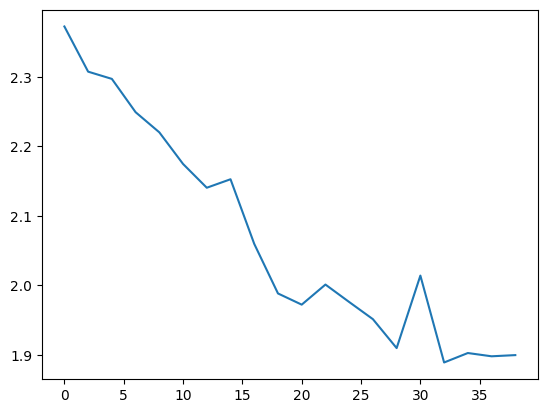

In [ ]:
df_log["loss"].dropna().plot()

<Axes: >

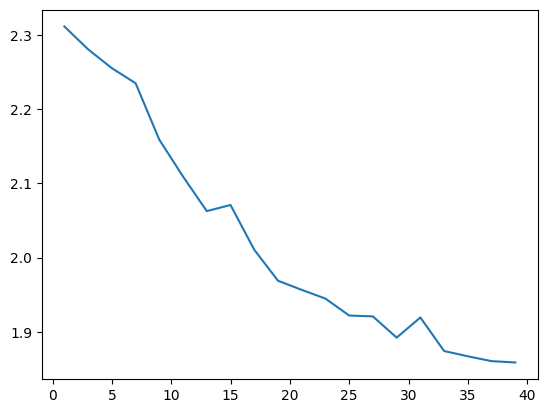

In [ ]:
df_log["eval_loss"].dropna().plot()

<Axes: >

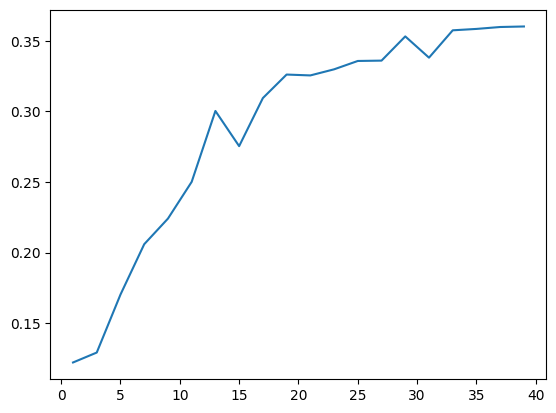

In [ ]:
df_log["eval_accuracy"].dropna().plot()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
trainer.evaluate(tokenized_small_test_dataset)

{'eval_loss': 1.8694242238998413,
 'eval_accuracy': 0.35041666666666665,
 'eval_runtime': 687.8968,
 'eval_samples_per_second': 31.4,
 'eval_steps_per_second': 3.925,
 'epoch': 0.26}

In [ ]:
path = 'bert-movie'
trainer.save_model(path)
tokenizer.save_pretrained(path)

('bert-movie/tokenizer_config.json',
 'bert-movie/special_tokens_map.json',
 'bert-movie/vocab.txt',
 'bert-movie/added_tokens.json',
 'bert-movie/tokenizer.json')

In [3]:
file_id = "1rjgjmYMAu2f1L-Nu48qsMTPkwi8SwM3E"
url = f"https://drive.google.com/uc?id={file_id}"

folder_path = "./modelo"  # especifique a pasta onde baixara o arquivo
os.makedirs(folder_path, exist_ok=True) # cria a pasta de destino se necessário

output = "modelo/modelo.zip"  # especifique o nome do arquivo e a extensão do mesmo
gdown.download(url, output)

Downloading...
From: https://drive.google.com/uc?id=1rjgjmYMAu2f1L-Nu48qsMTPkwi8SwM3E
To: /content/modelo/modelo.zip
100%|██████████| 409M/409M [00:05<00:00, 70.3MB/s]


'modelo/modelo.zip'

In [4]:
destination = 'modelo/modelo-bert/' # path onde se encontra o arquivo 'train.zip'

os.makedirs(destination,exist_ok=True) # cria a pasta de destino se necessário

with zipfile.ZipFile(output,'r') as zip_ref:
    zip_ref.extractall(destination)

In [30]:
import torch.nn.functional as F
import torch

model_path = 'modelo/modelo-bert/bert-movie'
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

text = "Meet Max, an ordinary guy with an extraordinary talent for finding himself in the most absurd and hilarious situations. Life is never dull when Max is around, and his misadventures are about to take him on a wild rollercoaster ride of laughter."
encoded_input = tokenizer(text, return_tensors="pt")
output = model(**encoded_input)
probs = F.softmax(output.logits, dim=1)
pred = torch.argmax(probs, dim=1)
print(probs)
pred

tensor([[0.0713, 0.0943, 0.0380, 0.2375, 0.1180, 0.0822, 0.0837, 0.1890, 0.0178,
         0.0683]], grad_fn=<SoftmaxBackward0>)


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 14>:14                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: values expected sparse tensor layout but got Strided

In [34]:
genre_mapping = {
    0: 'action',
    1: 'adventure',
    2: 'crime',
    3: 'family',
    4: 'fantasy',
    5: 'horror',
    6: 'mystery',
    7: 'romance',
    8: 'sci-fi',
    9: 'thriller'
}

pred_genre = genre_mapping[pred.item()]
print(pred_genre)

family


In [ ]:
encoded_input

4-fantasy\
5-horror\
3-family\
8-scifi\
0-action\
2-crime\
1-adventure\
6-mistery\
7-romance\
9-thiller